# pc

> Point Cloud data manipulation

In [ ]:
#| default_exp cli/pc

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
import zarr
import numpy as np
from matplotlib import pyplot as plt
import moraine.cli as mc
import moraine as mr

In [ ]:
#| export
import logging
import zarr
import numpy as np
import numexpr as ne
import time

import dask
from dask import array as da
from dask.distributed import Client, LocalCluster, progress

from moraine.cli.logging import mc_logger
import moraine as mr

In [ ]:
#| export
@mc_logger
def gix2bool(gix:str, # point cloud grid index
             is_pc:str, # output, output bool array
             shape:tuple[int], # shape of one image (nlines,width)
             chunks:tuple[int]= (1000,1000), # output chunk size 
            ):
    '''Convert pc grid index to bool 2d array'''
    logger = logging.getLogger(__name__)
    is_pc_path = is_pc

    gix_zarr = zarr.open(gix,mode='r')
    logger.zarr_info('gix',gix_zarr)
    assert gix_zarr.ndim == 2, "gix dimentation is not 2."
    logger.info('loading gix into memory.')
    gix = zarr.open(gix,mode='r')[:]

    logger.info('calculate the bool array')
    is_pc = np.zeros(shape,dtype=bool)
    is_pc[gix[0],gix[1]] = True

    is_pc_zarr = zarr.open(is_pc_path,'w',shape=shape,dtype=bool,chunks=chunks)
    logger.zarr_info('is_pc',is_pc_zarr)
    logger.info('write the bool array.')
    is_pc_zarr[:] = is_pc
    logger.info('write done.')

In [ ]:
#| export
@mc_logger
def bool2gix(is_pc:str, # input bool array
             gix:str, # output, point cloud grid index
             chunks:int=100000, # output point chunk size
            ):
    '''Convert bool 2d array to grid index'''
    gix_path = gix
    logger = logging.getLogger(__name__)

    is_pc_zarr = zarr.open(is_pc,'r')
    logger.zarr_info('is_pc', is_pc_zarr)
    logger.info('loading is_pc into memory.')
    is_pc = zarr.open(is_pc,mode='r')[:]
    
    logger.info('calculate the index')
    gix = np.stack(np.where(is_pc))

    gix_zarr = zarr.open(gix_path,'w',shape=gix.shape,dtype=bool,chunks=(2,chunks))
    logger.zarr_info('gix', gix_zarr)
    logger.info('write the gix.')
    gix_zarr[:] = gix
    logger.info('write done.')

In [ ]:
#| export
@mc_logger
def ras2pc(gix:str, # point cloud grid index
           ras:str|list, # path (in string) or list of path for raster data
           pc:str|list, # output, path (in string) or list of path for point cloud data
           chunks:int=None, # output point chunk size, same as gix by default
          ):
    '''Convert raster data to point cloud data'''
    logger = logging.getLogger(__name__)

    gix_zarr = zarr.open(gix,mode='r')
    if chunks is None: chunks = gix_zarr.chunks[1]
    logger.zarr_info(gix,gix_zarr)
    assert gix_zarr.ndim == 2, "gix dimentation is not 2."

    logger.info('loading gix into memory.')
    gix = zarr.open(gix,mode='r')[:]
    n_pc = gix.shape[1]

    if isinstance(ras,str):
        assert isinstance(pc,str)
        ras_list = [ras]; pc_list = [pc]
    else:
        assert isinstance(ras,list); assert isinstance(pc,list)
        ras_list = ras; pc_list = pc
        n_data = len(ras_list)

    logger.info('starting dask local cluster.')
    with LocalCluster(processes=False, threads_per_worker=2) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')
        _pc_list = ()
        for ras_path, pc_path in zip(ras_list,pc_list):
            logger.info(f'start to slice on {ras_path}')
            ras_zarr = zarr.open(ras_path,'r'); logger.zarr_info(ras_path, ras_zarr)
            ras = da.from_zarr(ras_path,chunks=(*ras_zarr.shape[:2],*ras_zarr.chunks[2:])); logger.darr_info('ras',ras)
            with dask.config.set(**{'array.slicing.split_large_chunks': False}):
                pc = ras.reshape(-1,*ras.shape[2:])[np.ravel_multi_index((gix[0],gix[1]),dims=ras.shape[:2])]
            logger.darr_info('pc', pc)
            logger.info('rechunk pc data:')
            pc = pc.rechunk((chunks,*pc.chunksize[1:]))
            logger.darr_info('pc', pc)
            _pc = pc.to_zarr(pc_path,overwrite=True,compute=False)
            # _pc.visualize(filename=f'_pc.svg')
            logger.info(f'saving to {pc_path}.')
            _pc_list += (_pc,)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_pc_list)
        progress(futures,notebook=False)
        time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')

    logger.info('dask cluster closed.')

Usage:

In [ ]:
logger = mc.get_logger()

In [ ]:
ras_data1 = np.random.rand(100,100).astype(np.float32)
ras_data2 = np.random.rand(100,100,3).astype(np.float32)+1j*np.random.rand(100,100,3).astype(np.float32)

gix = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix.sort()
gix = np.stack(np.unravel_index(gix,shape=(100,100))).astype(np.int32)

pc_data1 = ras_data1[gix[0],gix[1]]
pc_data2 = ras_data2[gix[0],gix[1]]

gix_zarr = zarr.open('pc/gix.zarr','w',shape=gix.shape,dtype=gix.dtype,chunks=(2,200))
ras_zarr1 = zarr.open('pc/ras1.zarr','w',shape=ras_data1.shape,dtype=ras_data1.dtype,chunks=(20,100))
ras_zarr2 = zarr.open('pc/ras2.zarr','w',shape=ras_data2.shape,dtype=ras_data2.dtype,chunks=(20,100,1))
gix_zarr[:] = gix
ras_zarr1[:] = ras_data1
ras_zarr2[:] = ras_data2

In [ ]:
ras2pc('pc/gix.zarr','pc/ras1.zarr','pc/pc1.zarr')
pc_zarr1 = zarr.open('pc/pc1.zarr','r')
np.testing.assert_array_equal(pc_data1,pc_zarr1[:])

ras2pc('pc/gix.zarr',ras=['pc/ras1.zarr','pc/ras2.zarr'],pc=['pc/pc1.zarr','pc/pc2.zarr'])
pc_zarr1 = zarr.open('pc/pc1.zarr','r')
pc_zarr2 = zarr.open('pc/pc2.zarr','r')
np.testing.assert_array_equal(pc_data1,pc_zarr1[:])
np.testing.assert_array_equal(pc_data2,pc_zarr2[:])

2024-05-03 17:34:24 - log_args - INFO - running function: ras2pc
2024-05-03 17:34:24 - log_args - INFO - fetching args:
2024-05-03 17:34:24 - log_args - INFO - gix = 'pc/gix.zarr'
2024-05-03 17:34:24 - log_args - INFO - ras = 'pc/ras1.zarr'
2024-05-03 17:34:24 - log_args - INFO - pc = 'pc/pc1.zarr'
2024-05-03 17:34:24 - log_args - INFO - chunks = None
2024-05-03 17:34:24 - log_args - INFO - fetching args done.
2024-05-03 17:34:24 - zarr_info - INFO - pc/gix.zarr zarray shape: (2, 1000)
2024-05-03 17:34:24 - zarr_info - INFO - pc/gix.zarr zarray chunks: (2, 200)
2024-05-03 17:34:24 - zarr_info - INFO - pc/gix.zarr zarray dtype: int32
2024-05-03 17:34:24 - ras2pc - INFO - loading gix into memory.
2024-05-03 17:34:24 - ras2pc - INFO - starting dask local cluster.
2024-05-03 17:34:24 - ras2pc - INFO - dask local cluster started.
2024-05-03 17:34:24 - ras2pc - INFO - start to slice on pc/ras1.zarr
2024-05-03 17:34:24 - zarr_info - INFO - pc/ras1.zarr zarray shape: (100, 100)
2024-05-03 17:3

In [ ]:
#| export
@mc_logger
def pc2ras(gix:str, # point cloud grid index
           pc:str|list, # path (in string) or list of path for point cloud data
           ras:str|list, # output, path (in string) or list of path for raster data
           shape:tuple[int], # shape of one image (nlines,width)
           chunks:tuple[int]=(1000,1000), # output chunk size
          ):
    '''Convert point cloud data to raster data, filled with nan'''
    logger = logging.getLogger(__name__)

    gix_zarr = zarr.open(gix,mode='r')
    logger.zarr_info('gix', gix_zarr)
    assert gix_zarr.ndim == 2, "gix dimentation is not 2."

    logger.info('loading gix into memory.')
    gix = zarr.open(gix,mode='r')[:]
    n_pc = gix.shape[1]
    
    if isinstance(pc,str):
        assert isinstance(ras,str)
        pc_list = [pc]; ras_list = [ras]
    else:
        assert isinstance(pc,list); assert isinstance(ras,list)
        pc_list = pc; ras_list = ras

    logger.info('starting dask local cluster.')
    with LocalCluster(processes=False, threads_per_worker=2) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')

        _ras_list = ()

        for ras_path, pc_path in zip(ras_list,pc_list):
            logger.info(f'start to work on {pc_path}')
            pc_zarr = zarr.open(pc_path,'r')
            logger.zarr_info(pc_path,pc_zarr)

            pc = da.from_zarr(pc_path, chunks=(pc_zarr.shape[0],*pc_zarr.chunks[1:]))
            logger.darr_info('pc', pc)
            ras = da.empty((shape[0]*shape[1],*pc.shape[1:]),chunks = (chunks[0]*shape[1],*pc_zarr.chunks[1:]), dtype=pc.dtype)
            ras[:] = np.nan
            ras[np.ravel_multi_index((gix[0],gix[1]),dims=shape)] = pc
            ras = ras.reshape(*shape,*pc.shape[1:])
            ras.rechunk((*chunks,*pc_zarr.chunks[1:]))
            logger.info('create ras dask array')
            logger.darr_info('ras', ras)
            _ras = ras.to_zarr(ras_path,overwrite=True,compute=False)
            _ras_list += (_ras,)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_ras_list)
        progress(futures,notebook=False)
        time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')

    logger.info('dask cluster closed.')

Usage:

In [ ]:
pc_data1 = np.random.rand(1000).astype(np.float32)
pc_data2 = np.random.rand(1000,3).astype(np.float32)+1j*np.random.rand(1000,3).astype(np.float32)

gix = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix.sort()
gix = np.stack(np.unravel_index(gix,shape=(100,100))).astype(np.int32)

ras_data1 = np.zeros((100,100),dtype=np.float32)
ras_data2 = np.zeros((100,100,3),dtype=np.complex64)
ras_data1[:] = np.nan
ras_data2[:] = np.nan

ras_data1[gix[0],gix[1]] = pc_data1
ras_data2[gix[0],gix[1]] = pc_data2

gix_zarr = zarr.open('pc/gix.zarr','w',shape=gix.shape,dtype=gix.dtype,chunks=(2,200))
pc_zarr1 = zarr.open('pc/pc1.zarr','w',shape=pc_data1.shape,dtype=pc_data1.dtype,chunks=(200,))
pc_zarr2 = zarr.open('pc/pc2.zarr','w',shape=pc_data2.shape,dtype=pc_data2.dtype,chunks=(200,1))
gix_zarr[:] = gix
pc_zarr1[:] = pc_data1
pc_zarr2[:] = pc_data2

In [ ]:
pc2ras('pc/gix.zarr','pc/pc1.zarr','pc/ras1.zarr',shape=(100,100),chunks=(20,100))
ras_zarr1 = zarr.open('pc/ras1.zarr','r')
np.testing.assert_array_equal(ras_data1,ras_zarr1[:])

pc2ras('pc/gix.zarr',['pc/pc1.zarr','pc/pc2.zarr'],['pc/ras1.zarr','pc/ras2.zarr'],shape=(100,100),chunks=(20,100))
ras_zarr1 = zarr.open('pc/ras1.zarr','r')
ras_zarr2 = zarr.open('pc/ras2.zarr','r')
np.testing.assert_array_equal(ras_data1,ras_zarr1[:])
np.testing.assert_array_equal(ras_data2,ras_zarr2[:])

2024-05-03 17:35:22 - log_args - INFO - running function: pc2ras
2024-05-03 17:35:22 - log_args - INFO - fetching args:
2024-05-03 17:35:22 - log_args - INFO - gix = 'pc/gix.zarr'
2024-05-03 17:35:22 - log_args - INFO - pc = 'pc/pc1.zarr'
2024-05-03 17:35:22 - log_args - INFO - ras = 'pc/ras1.zarr'
2024-05-03 17:35:22 - log_args - INFO - shape = (100, 100)
2024-05-03 17:35:22 - log_args - INFO - chunks = (20, 100)
2024-05-03 17:35:22 - log_args - INFO - fetching args done.
2024-05-03 17:35:22 - zarr_info - INFO - gix zarray shape: (2, 1000)
2024-05-03 17:35:22 - zarr_info - INFO - gix zarray chunks: (2, 200)
2024-05-03 17:35:22 - zarr_info - INFO - gix zarray dtype: int32
2024-05-03 17:35:22 - pc2ras - INFO - loading gix into memory.
2024-05-03 17:35:22 - pc2ras - INFO - starting dask local cluster.
2024-05-03 17:35:22 - pc2ras - INFO - dask local cluster started.
2024-05-03 17:35:22 - pc2ras - INFO - start to work on pc/pc1.zarr
2024-05-03 17:35:22 - zarr_info - INFO - pc/pc1.zarr zar

In [ ]:
#| export
@mc_logger
def pc_hix(
    gix:str, # grid index
    hix:str, # output, path
    shape:tuple, # (nlines, width
):
    '''Compute the hillbert index from grid index for point cloud data.
    '''
    logger = logging.getLogger(__name__)
    gix_zarr = zarr.open(gix,'r')
    hix_zarr = zarr.open(hix, 'w', chunks=gix_zarr.chunks[1], dtype=np.int64, shape=gix_zarr.shape[1])
    logger.info('calculating the hillbert index based on grid index')
    hix_data = mr.pc_hix(gix_zarr[:],shape=shape)
    logger.info("writing the hillbert index")
    hix_zarr[:] = hix_data
    logger.info("done.")

Usage:

In [ ]:
bbox = [0,0,100,100]
gix = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix.sort()
gix = np.stack(np.unravel_index(gix,shape=(100,100))).astype(np.int32)
gix_zarr = zarr.open('pc/gix.zarr','w',shape=gix.shape, chunks=(2,100),dtype=gix.dtype)
gix_zarr[:] = gix

In [ ]:
pc_hix('pc/gix.zarr', 'pc/hix.zarr',shape=(100,100))

2024-05-03 17:35:28 - log_args - INFO - running function: pc_hix
2024-05-03 17:35:28 - log_args - INFO - fetching args:
2024-05-03 17:35:28 - log_args - INFO - gix = 'pc/gix.zarr'
2024-05-03 17:35:28 - log_args - INFO - hix = 'pc/hix.zarr'
2024-05-03 17:35:28 - log_args - INFO - shape = (100, 100)
2024-05-03 17:35:28 - log_args - INFO - fetching args done.
2024-05-03 17:35:29 - pc_hix - INFO - calculating the hillbert index based on grid index
2024-05-03 17:35:30 - pc_hix - INFO - writing the hillbert index
2024-05-03 17:35:30 - pc_hix - INFO - done.


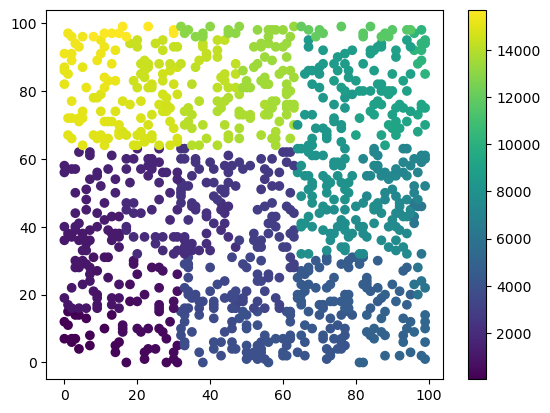

In [ ]:
hix = zarr.open('pc/hix.zarr','r')[:]
plt.scatter(gix[1], gix[0], c=hix)
plt.colorbar()
plt.show()

In [ ]:
#| export
@mc_logger
def pc_gix(
    hix:str, # grid index
    gix:str, # output, path
    shape:tuple, # (nlines, width
):
    '''Compute the hillbert index from grid index for point cloud data.
    '''
    logger = logging.getLogger(__name__)
    hix_zarr = zarr.open(hix,'r')
    gix_zarr = zarr.open(gix, 'w', chunks=(2, hix_zarr.chunks[0]), dtype=np.int32, shape=(2,hix_zarr.shape[0]))
    logger.info('calculating the grid index from hillbert index')
    gix_data = mr.pc_gix(hix_zarr[:],shape=shape)
    logger.info("writing the grid index")
    gix_zarr[:] = gix_data
    logger.info("done.")

In [ ]:
bbox = [0,0,100,100]
gix = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix.sort()
gix = np.stack(np.unravel_index(gix,shape=(100,100))).astype(np.int32)
gix_zarr = zarr.open('pc/gix.zarr','w',shape=gix.shape, chunks=(2,100),dtype=gix.dtype)
gix_zarr[:] = gix
pc_hix('pc/gix.zarr', 'pc/hix.zarr',shape=(100,100))
pc_gix('pc/hix.zarr','pc/gix_.zarr', (100,100))
np.testing.assert_array_equal(zarr.open('pc/gix_.zarr','r')[:], gix)

2024-05-03 17:35:31 - log_args - INFO - running function: pc_hix
2024-05-03 17:35:31 - log_args - INFO - fetching args:
2024-05-03 17:35:31 - log_args - INFO - gix = 'pc/gix.zarr'
2024-05-03 17:35:31 - log_args - INFO - hix = 'pc/hix.zarr'
2024-05-03 17:35:31 - log_args - INFO - shape = (100, 100)
2024-05-03 17:35:31 - log_args - INFO - fetching args done.
2024-05-03 17:35:31 - pc_hix - INFO - calculating the hillbert index based on grid index
2024-05-03 17:35:31 - pc_hix - INFO - writing the hillbert index
2024-05-03 17:35:31 - pc_hix - INFO - done.
2024-05-03 17:35:31 - log_args - INFO - running function: pc_gix
2024-05-03 17:35:31 - log_args - INFO - fetching args:
2024-05-03 17:35:31 - log_args - INFO - hix = 'pc/hix.zarr'
2024-05-03 17:35:31 - log_args - INFO - gix = 'pc/gix_.zarr'
2024-05-03 17:35:31 - log_args - INFO - shape = (100, 100)
2024-05-03 17:35:31 - log_args - INFO - fetching args done.
2024-05-03 17:35:31 - pc_gix - INFO - calculating the grid index from hillbert inde

In [ ]:
#| export
@mc_logger
def pc_sort(idx_in:str, # the unsorted grid index or hillbert index of the input data
            idx:str, # output, the sorted grid index or hillbert index
            pc_in:str|list, # path (in string) or list of path for the input point cloud data
            pc:str|list, # output, path (in string) or list of path for the output point cloud data
            chunks:int=None, # chunk size in output data, same as `idx_in` by default
           ):
    '''Sort point cloud data according to the indices that sort `idx_in`.
    '''
    idx_in_path = idx_in
    logger = logging.getLogger(__name__)
    idx_in_zarr = zarr.open(idx_in_path,mode='r'); logger.zarr_info(idx_in_path,idx_in_zarr)
    logger.info('loading idx_in and calculate the sorting indices.')
    idx_in = idx_in_zarr[:]; iidx = mr.pc_sort(idx_in)
    n_pc = idx_in_zarr.shape[-1]
    if chunks is None: chunks = idx_in_zarr.chunks[-1] 
    logger.info(f'output pc chunk size is {chunks}')
    idx_chunk_size = (2, chunks) if idx_in.ndim == 2 else (chunks,)
    idx_zarr = zarr.open(idx,'w', shape=idx_in_zarr.shape, dtype=idx_in.dtype, chunks=idx_chunk_size)
    logger.info('write idx'); logger.zarr_info('idx', idx_zarr)
    idx_zarr[:] = idx_in[...,iidx]

    if isinstance(pc_in,str):
        assert isinstance(pc,str)
        pc_in_list = [pc_in]; pc_list = [pc]
    else:
        assert isinstance(pc_in,list); assert isinstance(pc,list)
        pc_in_list = pc_in; pc_list = pc

    logger.info('starting dask local cluster.')
    with LocalCluster(processes=False, threads_per_worker=2) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')

        _pc_list = ()
        for pc_in_path, pc_path in zip(pc_in_list,pc_list):
            pc_in_zarr = zarr.open(pc_in_path,'r'); logger.zarr_info(pc_in_path, pc_in_zarr)
            pc_in = da.from_zarr(pc_in_zarr,chunks=(n_pc,*pc_in_zarr.chunks[1:]))
            logger.darr_info('pc_in', pc_in)
            logger.info('set up sorted pc data dask array.')
            pc = da.empty(pc_in.shape,chunks = pc_in.chunks, dtype=pc_in.dtype)
            logger.darr_info('pc',pc)
            pc[:] = pc_in[iidx]
            logger.info('rechunk dask array for writing.')
            pc = pc.rechunk((chunks,*pc.chunks[1:]))
            logger.darr_info('pc',pc)
            logger.info('write')
            _pc = pc.to_zarr(pc_path, overwrite=True,compute=False)
            # _pc.visualize(filename=f'_pc.svg')
            _pc_list += (_pc,)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_pc_list)
        progress(futures,notebook=False)
        time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

In [ ]:
pc_in = np.random.rand(1000).astype(np.float32)
gix_in = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix_in = np.stack(np.unravel_index(gix_in,shape=(100,100))).astype(np.int32)
ind = np.lexsort((gix_in[1],gix_in[0]))
pc = pc_in[ind]; gix = gix_in[:,ind]

pc_in_zarr = zarr.open('pc/pc_in.zarr','w',shape=pc_in.shape,dtype=pc_in.dtype,chunks=(100,))
gix_in_zarr = zarr.open('pc/gix_in.zarr','w',shape=gix_in.shape,dtype=gix_in.dtype,chunks=(2,100))
pc_in_zarr[:] = pc_in; gix_in_zarr[:] = gix_in

In [ ]:
pc_sort('pc/gix_in.zarr','pc/gix.zarr','pc/pc_in.zarr','pc/pc.zarr')
pc_zarr = zarr.open('pc/pc.zarr','r'); gix_zarr = zarr.open('pc/gix.zarr','r')
np.testing.assert_array_equal(pc_zarr[:],pc)
np.testing.assert_array_equal(gix_zarr[:],gix)

2024-05-03 17:35:36 - log_args - INFO - running function: pc_sort
2024-05-03 17:35:36 - log_args - INFO - fetching args:
2024-05-03 17:35:36 - log_args - INFO - idx_in = 'pc/gix_in.zarr'
2024-05-03 17:35:36 - log_args - INFO - idx = 'pc/gix.zarr'
2024-05-03 17:35:36 - log_args - INFO - pc_in = 'pc/pc_in.zarr'
2024-05-03 17:35:36 - log_args - INFO - pc = 'pc/pc.zarr'
2024-05-03 17:35:36 - log_args - INFO - chunks = None
2024-05-03 17:35:36 - log_args - INFO - fetching args done.
2024-05-03 17:35:36 - zarr_info - INFO - pc/gix_in.zarr zarray shape: (2, 1000)
2024-05-03 17:35:36 - zarr_info - INFO - pc/gix_in.zarr zarray chunks: (2, 100)
2024-05-03 17:35:36 - zarr_info - INFO - pc/gix_in.zarr zarray dtype: int32
2024-05-03 17:35:36 - pc_sort - INFO - loading idx_in and calculate the sorting indices.
2024-05-03 17:35:36 - pc_sort - INFO - output pc chunk size is 100
2024-05-03 17:35:36 - pc_sort - INFO - write idx
2024-05-03 17:35:36 - zarr_info - INFO - idx zarray shape: (2, 1000)
2024-05

In [ ]:
pc_in = np.random.rand(1000).astype(np.float32)
hix_in = np.random.choice(np.arange(100*100,dtype=np.int64),size=1000,replace=False)
ind = np.argsort(hix_in,kind='stable')
pc = pc_in[ind]; hix = hix_in[ind]

pc_in_zarr = zarr.open('pc/pc_in.zarr','w',shape=pc_in.shape,dtype=pc_in.dtype,chunks=(100,))
hix_in_zarr = zarr.open('pc/hix_in.zarr','w',shape=hix_in.shape,dtype=hix_in.dtype,chunks=(100,))
pc_in_zarr[:] = pc_in; hix_in_zarr[:] = hix_in

pc_sort('pc/hix_in.zarr','pc/hix.zarr','pc/pc_in.zarr','pc/pc.zarr')
pc_zarr = zarr.open('pc/pc.zarr','r'); hix_zarr = zarr.open('pc/hix.zarr','r')
np.testing.assert_array_equal(pc_zarr[:],pc)
np.testing.assert_array_equal(hix_zarr[:],hix)

2024-05-03 17:35:36 - log_args - INFO - running function: pc_sort
2024-05-03 17:35:36 - log_args - INFO - fetching args:
2024-05-03 17:35:36 - log_args - INFO - idx_in = 'pc/hix_in.zarr'
2024-05-03 17:35:36 - log_args - INFO - idx = 'pc/hix.zarr'
2024-05-03 17:35:36 - log_args - INFO - pc_in = 'pc/pc_in.zarr'
2024-05-03 17:35:36 - log_args - INFO - pc = 'pc/pc.zarr'
2024-05-03 17:35:36 - log_args - INFO - chunks = None
2024-05-03 17:35:36 - log_args - INFO - fetching args done.
2024-05-03 17:35:36 - zarr_info - INFO - pc/hix_in.zarr zarray shape: (1000,)
2024-05-03 17:35:36 - zarr_info - INFO - pc/hix_in.zarr zarray chunks: (100,)
2024-05-03 17:35:36 - zarr_info - INFO - pc/hix_in.zarr zarray dtype: int64
2024-05-03 17:35:36 - pc_sort - INFO - loading idx_in and calculate the sorting indices.
2024-05-03 17:35:36 - pc_sort - INFO - output pc chunk size is 100
2024-05-03 17:35:36 - pc_sort - INFO - write idx
2024-05-03 17:35:36 - zarr_info - INFO - idx zarray shape: (1000,)
2024-05-03 17

In [ ]:
#| export
@mc_logger
def pc_union(idx1:str, # grid index or hillbert index of the first point cloud
             idx2:str, # grid index or hillbert index of the second point cloud
             idx:str, # output, grid index or hillbert index of the union point cloud
             pc1:str|list=None, # path (in string) or list of path for the first point cloud data
             pc2:str|list=None, # path (in string) or list of path for the second point cloud data
             pc:str|list=None, #output, path (in string) or list of path for the union point cloud data
             chunks:int=None, # chunk size in output data, same as `idx1` by default
            ):
    '''Get the union of two point cloud dataset.
    For points at their intersection, pc_data1 rather than pc_data2 is copied to the result pc_data.
    `pc_chunk_size` and `n_pc_chunk` are used to determine the final pc_chunk_size.
    If non of them are provided, the pc_chunk_size is setted as it in idx1.
    '''
    logger = logging.getLogger(__name__)

    idx1_zarr = zarr.open(idx1,mode='r'); logger.zarr_info(idx1,idx1_zarr)
    idx2_zarr = zarr.open(idx2,mode='r'); logger.zarr_info(idx2,idx2_zarr)
    logger.info('loading idx1 and idx2 into memory.')
    idx1 = idx1_zarr[:]; idx2 = idx2_zarr[:]

    logger.info('calculate the union')
    idx_path = idx
    idx, inv_iidx1, inv_iidx2, iidx2 = mr.pc_union(idx1,idx2)
    n_pc = idx.shape[-1]
    logger.info(f'number of points in the union: {n_pc}')
    if chunks is None: chunks = idx1_zarr.chunks[-1] 
    idx_chunk_size = (2, chunks) if idx.ndim == 2 else (chunks,)
    idx_zarr = zarr.open(idx_path,'w',shape=idx.shape,dtype=idx.dtype,chunks=idx_chunk_size)
    logger.info('write union idx')
    idx_zarr[:] = idx
    logger.info('write done')
    logger.zarr_info(idx_path, idx_zarr)
    
    if pc1 is None:
        logger.info('no point cloud data provided, exit.')
        return None

    if isinstance(pc1,str):
        assert isinstance(pc2,str); assert isinstance(pc,str)
        pc1_list = [pc1]; pc2_list = [pc2]; pc_list = [pc]
    else:
        assert isinstance(pc1,list); assert isinstance(pc2,list); assert isinstance(pc,list)
        pc1_list = pc1; pc2_list = pc2; pc_list = pc

    logger.info('starting dask local cluster.')
    with LocalCluster(processes=False, n_workers=1, threads_per_worker=2) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')

        _pc_list = ()
        for pc1_path, pc2_path, pc_path in zip(pc1_list,pc2_list,pc_list):
            pc1_zarr = zarr.open(pc1_path,'r'); pc2_zarr = zarr.open(pc2_path,'r')
            logger.zarr_info(pc1_path, pc1_zarr); logger.zarr_info(pc2_path, pc2_zarr);
            pc1 = da.from_zarr(pc1_path,chunks=(pc1_zarr.shape[0],*pc1_zarr.chunks[1:]))
            pc2 = da.from_zarr(pc2_path,chunks=(pc2_zarr.shape[0],*pc2_zarr.chunks[1:]))
            logger.darr_info('pc1', pc1); logger.darr_info('pc2',pc2)
            logger.info('set up union pc data dask array.')
            pc = da.empty((n_pc,*pc1.shape[1:]),chunks = (n_pc,*pc1.chunks[1:]), dtype=pc1.dtype)
            logger.darr_info('pc',pc)
            pc[inv_iidx1] = pc1
            pc[inv_iidx2] = pc2[iidx2]
            logger.info('rechunk dask array for writing.')
            pc = pc.rechunk((chunks,*pc.chunks[1:]))
            logger.darr_info('pc',pc)
            logger.info('write')
            # pc.visualize(filename=f'pc.svg')
            _pc = pc.to_zarr(pc_path, overwrite=True,compute=False)
            _pc_list += (_pc,)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_pc_list)
        progress(futures,notebook=False); time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')

    logger.info('dask cluster closed.')

Usage:

In [ ]:
pc_data1 = np.random.rand(1000,3).astype(np.float32)+1j*np.random.rand(1000,3).astype(np.float32)
pc_data2 = np.random.rand(800,3).astype(np.float32)+1j*np.random.rand(800,3).astype(np.float32)

gix1 = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix1.sort()
gix1 = np.stack(np.unravel_index(gix1,shape=(100,100))).astype(np.int32)

gix2 = np.random.choice(np.arange(100*100,dtype=np.int32),size=800,replace=False)
gix2.sort()
gix2 = np.stack(np.unravel_index(gix2,shape=(100,100))).astype(np.int32)

gix, inv_iidx1, inv_iidx2, iidx2 = mr.pc_union(gix1,gix2)

pc_data = np.empty((gix.shape[1],*pc_data1.shape[1:]),dtype=pc_data1.dtype)
pc_data[inv_iidx1] = pc_data1
pc_data[inv_iidx2] = pc_data2[iidx2]

gix1_zarr = zarr.open('pc/gix1.zarr','w',shape=gix1.shape,dtype=gix1.dtype,chunks=(2,200))
gix2_zarr = zarr.open('pc/gix2.zarr','w',shape=gix2.shape,dtype=gix2.dtype,chunks=(2,200))
pc1_zarr = zarr.open('pc/pc1.zarr','w',shape=pc_data1.shape,dtype=pc_data1.dtype,chunks=(200,1))
pc2_zarr = zarr.open('pc/pc2.zarr','w',shape=pc_data2.shape,dtype=pc_data2.dtype,chunks=(200,1))
gix1_zarr[:] = gix1
gix2_zarr[:] = gix2
pc1_zarr[:] = pc_data1
pc2_zarr[:] = pc_data2

In [ ]:
pc_union('pc/gix1.zarr','pc/gix2.zarr','pc/gix.zarr')
pc_union('pc/gix1.zarr','pc/gix2.zarr','pc/gix.zarr','pc/pc1.zarr','pc/pc2.zarr','pc/pc.zarr')
gix_zarr = zarr.open('pc/gix.zarr','r')
pc_zarr = zarr.open('pc/pc.zarr','r')
np.testing.assert_array_equal(gix_zarr[:],gix)
np.testing.assert_array_equal(pc_zarr[:],pc_data)

2024-05-03 17:35:37 - log_args - INFO - running function: pc_union
2024-05-03 17:35:37 - log_args - INFO - fetching args:
2024-05-03 17:35:37 - log_args - INFO - idx1 = 'pc/gix1.zarr'
2024-05-03 17:35:37 - log_args - INFO - idx2 = 'pc/gix2.zarr'
2024-05-03 17:35:37 - log_args - INFO - idx = 'pc/gix.zarr'
2024-05-03 17:35:37 - log_args - INFO - pc1 = None
2024-05-03 17:35:37 - log_args - INFO - pc2 = None
2024-05-03 17:35:37 - log_args - INFO - pc = None
2024-05-03 17:35:37 - log_args - INFO - chunks = None
2024-05-03 17:35:37 - log_args - INFO - fetching args done.
2024-05-03 17:35:37 - zarr_info - INFO - pc/gix1.zarr zarray shape: (2, 1000)
2024-05-03 17:35:37 - zarr_info - INFO - pc/gix1.zarr zarray chunks: (2, 200)
2024-05-03 17:35:37 - zarr_info - INFO - pc/gix1.zarr zarray dtype: int32
2024-05-03 17:35:37 - zarr_info - INFO - pc/gix2.zarr zarray shape: (2, 800)
2024-05-03 17:35:37 - zarr_info - INFO - pc/gix2.zarr zarray chunks: (2, 200)
2024-05-03 17:35:37 - zarr_info - INFO - pc

In [ ]:
pc_data1 = np.random.rand(1000,3).astype(np.float32)+1j*np.random.rand(1000,3).astype(np.float32)
pc_data2 = np.random.rand(800,3).astype(np.float32)+1j*np.random.rand(800,3).astype(np.float32)

hix1 = np.random.choice(np.arange(100*100,dtype=np.int64),size=1000,replace=False)
hix1.sort()

hix2 = np.random.choice(np.arange(100*100,dtype=np.int64),size=800,replace=False)
hix2.sort()

hix, inv_iidx1, inv_iidx2, iidx2 = mr.pc_union(hix1,hix2)

pc_data = np.empty((hix.shape[-1],*pc_data1.shape[1:]),dtype=pc_data1.dtype)
pc_data[inv_iidx1] = pc_data1
pc_data[inv_iidx2] = pc_data2[iidx2]

hix1_zarr = zarr.open('pc/hix1.zarr','w',shape=hix1.shape,dtype=hix1.dtype,chunks=(200,))
hix2_zarr = zarr.open('pc/hix2.zarr','w',shape=hix2.shape,dtype=hix2.dtype,chunks=(200,))
pc1_zarr = zarr.open('pc/pc1.zarr','w',shape=pc_data1.shape,dtype=pc_data1.dtype,chunks=(200,1))
pc2_zarr = zarr.open('pc/pc2.zarr','w',shape=pc_data2.shape,dtype=pc_data2.dtype,chunks=(200,1))
hix1_zarr[:] = hix1
hix2_zarr[:] = hix2
pc1_zarr[:] = pc_data1
pc2_zarr[:] = pc_data2

In [ ]:
pc_union('pc/hix1.zarr','pc/hix2.zarr','pc/hix.zarr')
pc_union('pc/hix1.zarr','pc/hix2.zarr','pc/hix.zarr','pc/pc1.zarr','pc/pc2.zarr','pc/pc.zarr')
hix_zarr = zarr.open('pc/hix.zarr','r')
pc_zarr = zarr.open('pc/pc.zarr','r')
np.testing.assert_array_equal(hix_zarr[:],hix)
np.testing.assert_array_equal(pc_zarr[:],pc_data)

2024-05-03 17:35:38 - log_args - INFO - running function: pc_union
2024-05-03 17:35:38 - log_args - INFO - fetching args:
2024-05-03 17:35:38 - log_args - INFO - idx1 = 'pc/hix1.zarr'
2024-05-03 17:35:38 - log_args - INFO - idx2 = 'pc/hix2.zarr'
2024-05-03 17:35:38 - log_args - INFO - idx = 'pc/hix.zarr'
2024-05-03 17:35:38 - log_args - INFO - pc1 = None
2024-05-03 17:35:38 - log_args - INFO - pc2 = None
2024-05-03 17:35:38 - log_args - INFO - pc = None
2024-05-03 17:35:38 - log_args - INFO - chunks = None
2024-05-03 17:35:38 - log_args - INFO - fetching args done.
2024-05-03 17:35:38 - zarr_info - INFO - pc/hix1.zarr zarray shape: (1000,)
2024-05-03 17:35:38 - zarr_info - INFO - pc/hix1.zarr zarray chunks: (200,)
2024-05-03 17:35:38 - zarr_info - INFO - pc/hix1.zarr zarray dtype: int64
2024-05-03 17:35:38 - zarr_info - INFO - pc/hix2.zarr zarray shape: (800,)
2024-05-03 17:35:38 - zarr_info - INFO - pc/hix2.zarr zarray chunks: (200,)
2024-05-03 17:35:38 - zarr_info - INFO - pc/hix2.za

In [ ]:
#| export
@mc_logger
def pc_intersect(idx1:str, # grid index or hillbert index of the first point cloud
                 idx2:str, # grid index or hillbert index of the second point cloud
                 idx:str, # output, grid index or hillbert index of the union point cloud
                 pc1:str|list=None, # path (in string) or list of path for the first point cloud data
                 pc2:str|list=None, # path (in string) or list of path for the second point cloud data
                 pc:str|list=None, #output, path (in string) or list of path for the union point cloud data
                 chunks:int=None, # chunk size in output data, same as `idx1` by default
                 prefer_1=True, # save pc1 on intersection to output pc dataset by default `True`. Otherwise, save data from pc2
                ):
    '''Get the intersection of two point cloud dataset.
    `pc_chunk_size` and `n_pc_chunk` are used to determine the final pc_chunk_size.
    If non of them are provided, the n_pc_chunk is set to n_chunk in idx1.
    '''
    logger = logging.getLogger(__name__)

    idx1_zarr = zarr.open(idx1,mode='r'); logger.zarr_info(idx1,idx1_zarr)
    idx2_zarr = zarr.open(idx2,mode='r'); logger.zarr_info(idx2,idx2_zarr)
    logger.info('loading idx1 and idx2 into memory.')
    idx1 = idx1_zarr[:]; idx2 = idx2_zarr[:]

    logger.info('calculate the intersection')
    idx_path = idx
    idx, iidx1, iidx2 = mr.pc_intersect(idx1,idx2)
    n_pc = idx.shape[-1]
    logger.info(f'number of points in the intersection: {n_pc}')
    if chunks is None: chunks = idx1_zarr.chunks[-1] 
    idx_chunk_size = (2, chunks) if idx.ndim == 2 else (chunks,)    
    idx_zarr = zarr.open(idx_path,'w',shape=idx.shape,dtype=idx.dtype,chunks=idx_chunk_size)
    logger.info('write intersect idx')
    idx_zarr[:] = idx
    logger.info('write done')
    logger.zarr_info(idx_path, idx_zarr)

    if (pc1 is None) and (pc2 is None):
        logger.info('no point cloud data provided, exit.')
        return None

    if prefer_1:
        logger.info('select pc1 as pc_input.')
        iidx = iidx1; pc_input = pc1
    else:
        logger.info('select pc2 as pc_input.')
        iidx = iidx2; pc_input = pc2

    if isinstance(pc_input,str):
        assert isinstance(pc,str)
        pc_input_list = [pc_input]; pc_list = [pc]
    else:
        assert isinstance(pc_input,list); assert isinstance(pc,list)
        pc_input_list = pc_input; pc_list = pc

    logger.info('starting dask local cluster.')
    with LocalCluster(processes=False, threads_per_worker=2) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')

        _pc_list = ()
        for pc_input_path, pc_path in zip(pc_input_list,pc_list):
            pc_input_zarr = zarr.open(pc_input_path,'r')
            logger.zarr_info(pc_input_path,pc_input_zarr)
            pc_input = da.from_zarr(pc_input_path)
            logger.darr_info('pc_input', pc_input)

            logger.info('set up intersect pc data dask array.')
            pc = da.empty((n_pc,*pc_input.shape[1:]),chunks = (n_pc,*pc_input.chunks[1:]), dtype=pc_input.dtype)
            logger.darr_info('pc',pc)
            pc[:] = pc_input[iidx]
            logger.info('rechunk dask array for writing.')
            pc = pc.rechunk((chunks,*pc.chunks[1:]))
            logger.darr_info('pc',pc)
            logger.info('write')
            # pc.visualize(filename=f'pc.svg')
            _pc = pc.to_zarr(pc_path, overwrite=True,compute=False)
            _pc_list += (_pc,)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_pc_list)
        progress(futures,notebook=False); time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

Usage:

In [ ]:
pc_data1 = np.random.rand(1000,3).astype(np.float32)+1j*np.random.rand(1000,3).astype(np.float32)
pc_data2 = np.random.rand(800,3).astype(np.float32)+1j*np.random.rand(800,3).astype(np.float32)

gix1 = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix1.sort()
gix1 = np.stack(np.unravel_index(gix1,shape=(100,100))).astype(np.int32)

gix2 = np.random.choice(np.arange(100*100,dtype=np.int32),size=800,replace=False)
gix2.sort()
gix2 = np.stack(np.unravel_index(gix2,shape=(100,100))).astype(np.int32)

gix, iidx1, iidx2 = mr.pc_intersect(gix1,gix2)

pc_data = np.empty((gix.shape[1],*pc_data1.shape[1:]),dtype=pc_data1.dtype)
pc_data[:] = pc_data2[iidx2]

gix1_zarr = zarr.open('pc/gix1.zarr','w',shape=gix1.shape,dtype=gix1.dtype,chunks=(2,200))
gix2_zarr = zarr.open('pc/gix2.zarr','w',shape=gix2.shape,dtype=gix2.dtype,chunks=(2,200))
pc1_zarr = zarr.open('pc/pc1.zarr','w',shape=pc_data1.shape,dtype=pc_data1.dtype,chunks=(200,1))
pc2_zarr = zarr.open('pc/pc2.zarr','w',shape=pc_data2.shape,dtype=pc_data2.dtype,chunks=(200,1))
gix1_zarr[:] = gix1
gix2_zarr[:] = gix2
pc1_zarr[:] = pc_data1
pc2_zarr[:] = pc_data2

In [ ]:
pc_intersect('pc/gix1.zarr','pc/gix2.zarr','pc/gix.zarr')
pc_intersect('pc/gix1.zarr','pc/gix2.zarr','pc/gix.zarr',pc2='pc/pc2.zarr', pc='pc/pc.zarr',prefer_1=False)
gix_zarr = zarr.open('pc/gix.zarr','r')
pc_zarr = zarr.open('pc/pc.zarr','r')
np.testing.assert_array_equal(gix_zarr[:],gix)
np.testing.assert_array_equal(pc_zarr[:],pc_data)

2024-05-03 17:35:39 - log_args - INFO - running function: pc_intersect
2024-05-03 17:35:39 - log_args - INFO - fetching args:
2024-05-03 17:35:39 - log_args - INFO - idx1 = 'pc/gix1.zarr'
2024-05-03 17:35:39 - log_args - INFO - idx2 = 'pc/gix2.zarr'
2024-05-03 17:35:39 - log_args - INFO - idx = 'pc/gix.zarr'
2024-05-03 17:35:39 - log_args - INFO - pc1 = None
2024-05-03 17:35:39 - log_args - INFO - pc2 = None
2024-05-03 17:35:39 - log_args - INFO - pc = None
2024-05-03 17:35:39 - log_args - INFO - chunks = None
2024-05-03 17:35:39 - log_args - INFO - prefer_1 = True
2024-05-03 17:35:39 - log_args - INFO - fetching args done.
2024-05-03 17:35:39 - zarr_info - INFO - pc/gix1.zarr zarray shape: (2, 1000)
2024-05-03 17:35:39 - zarr_info - INFO - pc/gix1.zarr zarray chunks: (2, 200)
2024-05-03 17:35:39 - zarr_info - INFO - pc/gix1.zarr zarray dtype: int32
2024-05-03 17:35:39 - zarr_info - INFO - pc/gix2.zarr zarray shape: (2, 800)
2024-05-03 17:35:39 - zarr_info - INFO - pc/gix2.zarr zarray 

In [ ]:
pc_data1 = np.random.rand(1000,3).astype(np.float32)+1j*np.random.rand(1000,3).astype(np.float32)
pc_data2 = np.random.rand(800,3).astype(np.float32)+1j*np.random.rand(800,3).astype(np.float32)

hix1 = np.random.choice(np.arange(100*100,dtype=np.int64),size=1000,replace=False)
hix1.sort()

hix2 = np.random.choice(np.arange(100*100,dtype=np.int64),size=800,replace=False)
hix2.sort()

hix, iidx1, iidx2 = mr.pc_intersect(hix1,hix2)

pc_data = np.empty((hix.shape[-1],*pc_data1.shape[1:]),dtype=pc_data1.dtype)
pc_data[:] = pc_data2[iidx2]

hix1_zarr = zarr.open('pc/hix1.zarr','w',shape=hix1.shape,dtype=hix1.dtype,chunks=(200,))
hix2_zarr = zarr.open('pc/hix2.zarr','w',shape=hix2.shape,dtype=hix2.dtype,chunks=(200,))
pc1_zarr = zarr.open('pc/pc1.zarr','w',shape=pc_data1.shape,dtype=pc_data1.dtype,chunks=(200,1))
pc2_zarr = zarr.open('pc/pc2.zarr','w',shape=pc_data2.shape,dtype=pc_data2.dtype,chunks=(200,1))
hix1_zarr[:] = hix1
hix2_zarr[:] = hix2
pc1_zarr[:] = pc_data1
pc2_zarr[:] = pc_data2

In [ ]:
pc_intersect('pc/hix1.zarr','pc/hix2.zarr','pc/hix.zarr')
pc_intersect('pc/hix1.zarr','pc/hix2.zarr','pc/hix.zarr',pc2='pc/pc2.zarr', pc='pc/pc.zarr',prefer_1=False)
hix_zarr = zarr.open('pc/hix.zarr','r')
pc_zarr = zarr.open('pc/pc.zarr','r')
np.testing.assert_array_equal(hix_zarr[:],hix)
np.testing.assert_array_equal(pc_zarr[:],pc_data)

2024-05-03 17:35:40 - log_args - INFO - running function: pc_intersect
2024-05-03 17:35:40 - log_args - INFO - fetching args:
2024-05-03 17:35:40 - log_args - INFO - idx1 = 'pc/hix1.zarr'
2024-05-03 17:35:40 - log_args - INFO - idx2 = 'pc/hix2.zarr'
2024-05-03 17:35:40 - log_args - INFO - idx = 'pc/hix.zarr'
2024-05-03 17:35:40 - log_args - INFO - pc1 = None
2024-05-03 17:35:40 - log_args - INFO - pc2 = None
2024-05-03 17:35:40 - log_args - INFO - pc = None
2024-05-03 17:35:40 - log_args - INFO - chunks = None
2024-05-03 17:35:40 - log_args - INFO - prefer_1 = True
2024-05-03 17:35:40 - log_args - INFO - fetching args done.
2024-05-03 17:35:40 - zarr_info - INFO - pc/hix1.zarr zarray shape: (1000,)
2024-05-03 17:35:40 - zarr_info - INFO - pc/hix1.zarr zarray chunks: (200,)
2024-05-03 17:35:40 - zarr_info - INFO - pc/hix1.zarr zarray dtype: int64
2024-05-03 17:35:40 - zarr_info - INFO - pc/hix2.zarr zarray shape: (800,)
2024-05-03 17:35:40 - zarr_info - INFO - pc/hix2.zarr zarray chunks

In [ ]:
#| export
@mc_logger
def pc_diff(idx1:str, # grid index or hillbert index of the first point cloud
            idx2:str, # grid index or hillbert index of the second point cloud
            idx:str, # output, grid index or hillbert index of the union point cloud
            pc1:str|list=None, # path (in string) or list of path for the first point cloud data
            pc:str|list=None, #output, path (in string) or list of path for the union point cloud data
            chunks:int=None, # chunk size in output data,optional
           ):
    '''Get the point cloud in `idx1` that are not in `idx2`.
    `pc_chunk_size` and `n_pc_chunk` are used to determine the final pc_chunk_size.
    If non of them are provided, the n_pc_chunk is set to n_chunk in idx1.
    '''
    logger = logging.getLogger(__name__)

    idx1_zarr = zarr.open(idx1,mode='r'); logger.zarr_info(idx1,idx1_zarr)
    idx2_zarr = zarr.open(idx2,mode='r'); logger.zarr_info(idx2,idx2_zarr)
    logger.info('loading idx1 and idx2 into memory.')
    idx1 = idx1_zarr[:]; idx2 = idx2_zarr[:]

    logger.info('calculate the diff.')
    idx_path = idx
    idx, iidx1 = mr.pc_diff(idx1,idx2)
    n_pc = idx.shape[-1]
    logger.info(f'number of points in the diff: {n_pc}')
    if chunks is None: chunks = idx1_zarr.chunks[-1] 
    idx_chunk_size = (2, chunks) if idx.ndim == 2 else (chunks,)
    idx_zarr = zarr.open(idx_path,'w',shape=idx.shape,dtype=idx.dtype,chunks=idx_chunk_size)
    logger.info('write intersect idx')
    idx_zarr[:] = idx
    logger.info('write done')
    logger.zarr_info(idx_path, idx_zarr)

    if pc1 is None:
        logger.info('no point cloud data provided, exit.')
        return None

    if isinstance(pc1,str):
        assert isinstance(pc,str)
        pc1_list = [pc1]; pc_list = [pc]
    else:
        assert isinstance(pc1,list); assert isinstance(pc,list)
        pc1_list = pc1; pc_list = pc

    logger.info('starting dask local cluster.')
    with LocalCluster(processes=False, threads_per_worker=2) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')

        _pc_list = ()
        for pc1_path, pc_path in zip(pc1_list,pc_list):
            pc1_zarr = zarr.open(pc1_path,'r'); logger.zarr_info(pc1_path, pc1_zarr)
            pc1 = da.from_zarr(pc1_path); logger.darr_info('pc1', pc1)
            logger.info('set up diff pc data dask array.')
            pc = da.empty((n_pc,*pc1.shape[1:]),chunks = (n_pc,*pc1.chunks[1:]), dtype=pc1.dtype)
            logger.darr_info('pc',pc)
            pc[:] = pc1[iidx1]
            logger.info('rechunk dask array for writing.')
            pc = pc.rechunk((chunks,*pc.chunks[1:]))
            logger.darr_info('pc',pc)
            logger.info('write')
            # pc.visualize(filename=f'pc.svg',optimize_graph=True)
            _pc = pc.to_zarr(pc_path, overwrite=True,compute=False)
            _pc_list += (_pc,)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_pc_list)
        progress(futures,notebook=False); time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

Usage:

In [ ]:
pc_data1 = np.random.rand(1000,3).astype(np.float32)+1j*np.random.rand(1000,3).astype(np.float32)

gix1 = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix1.sort()
gix1 = np.stack(np.unravel_index(gix1,shape=(100,100))).astype(np.int32)

gix2 = np.random.choice(np.arange(100*100,dtype=np.int32),size=800,replace=False)
gix2.sort()
gix2 = np.stack(np.unravel_index(gix2,shape=(100,100))).astype(np.int32)

gix, iidx1 = mr.pc_diff(gix1,gix2)

pc_data = np.empty((gix.shape[1],*pc_data1.shape[1:]),dtype=pc_data1.dtype)
pc_data[:] = pc_data1[iidx1]

gix1_zarr = zarr.open('pc/gix1.zarr','w',shape=gix1.shape,dtype=gix1.dtype,chunks=(2,200))
gix2_zarr = zarr.open('pc/gix2.zarr','w',shape=gix2.shape,dtype=gix2.dtype,chunks=(2,200))
pc1_zarr = zarr.open('pc/pc1.zarr','w',shape=pc_data1.shape,dtype=pc_data1.dtype,chunks=(200,1))
gix1_zarr[:] = gix1
gix2_zarr[:] = gix2
pc1_zarr[:] = pc_data1

In [ ]:
pc_diff('pc/gix1.zarr','pc/gix2.zarr','pc/gix.zarr')
pc_diff('pc/gix1.zarr','pc/gix2.zarr','pc/gix.zarr',pc1='pc/pc1.zarr', pc='pc/pc.zarr')
gix_zarr = zarr.open('pc/gix.zarr','r')
pc_zarr = zarr.open('pc/pc.zarr','r')
np.testing.assert_array_equal(gix_zarr[:],gix)
np.testing.assert_array_equal(pc_zarr[:],pc_data)

2024-05-03 17:35:41 - log_args - INFO - running function: pc_diff
2024-05-03 17:35:41 - log_args - INFO - fetching args:
2024-05-03 17:35:41 - log_args - INFO - idx1 = 'pc/gix1.zarr'
2024-05-03 17:35:41 - log_args - INFO - idx2 = 'pc/gix2.zarr'
2024-05-03 17:35:41 - log_args - INFO - idx = 'pc/gix.zarr'
2024-05-03 17:35:41 - log_args - INFO - pc1 = None
2024-05-03 17:35:41 - log_args - INFO - pc = None
2024-05-03 17:35:41 - log_args - INFO - chunks = None
2024-05-03 17:35:41 - log_args - INFO - fetching args done.
2024-05-03 17:35:41 - zarr_info - INFO - pc/gix1.zarr zarray shape: (2, 1000)
2024-05-03 17:35:41 - zarr_info - INFO - pc/gix1.zarr zarray chunks: (2, 200)
2024-05-03 17:35:41 - zarr_info - INFO - pc/gix1.zarr zarray dtype: int32
2024-05-03 17:35:41 - zarr_info - INFO - pc/gix2.zarr zarray shape: (2, 800)
2024-05-03 17:35:41 - zarr_info - INFO - pc/gix2.zarr zarray chunks: (2, 200)
2024-05-03 17:35:41 - zarr_info - INFO - pc/gix2.zarr zarray dtype: int32
2024-05-03 17:35:41 -

In [ ]:
pc_data1 = np.random.rand(1000,3).astype(np.float32)+1j*np.random.rand(1000,3).astype(np.float32)

hix1 = np.random.choice(np.arange(100*100,dtype=np.int64),size=1000,replace=False)
hix1.sort()

hix2 = np.random.choice(np.arange(100*100,dtype=np.int64),size=800,replace=False)
hix2.sort()

hix, iidx1 = mr.pc_diff(hix1,hix2)

pc_data = np.empty((hix.shape[-1],*pc_data1.shape[1:]),dtype=pc_data1.dtype)
pc_data[:] = pc_data1[iidx1]

hix1_zarr = zarr.open('pc/hix1.zarr','w',shape=hix1.shape,dtype=hix1.dtype,chunks=(200,))
hix2_zarr = zarr.open('pc/hix2.zarr','w',shape=hix2.shape,dtype=hix2.dtype,chunks=(200,))
pc1_zarr = zarr.open('pc/pc1.zarr','w',shape=pc_data1.shape,dtype=pc_data1.dtype,chunks=(200,1))
hix1_zarr[:] = hix1
hix2_zarr[:] = hix2
pc1_zarr[:] = pc_data1

In [ ]:
pc_diff('pc/hix1.zarr','pc/hix2.zarr','pc/hix.zarr')
pc_diff('pc/hix1.zarr','pc/hix2.zarr','pc/hix.zarr',pc1='pc/pc1.zarr', pc='pc/pc.zarr')
hix_zarr = zarr.open('pc/hix.zarr','r')
pc_zarr = zarr.open('pc/pc.zarr','r')
np.testing.assert_array_equal(hix_zarr[:],hix)
np.testing.assert_array_equal(pc_zarr[:],pc_data)

2024-05-03 17:35:41 - log_args - INFO - running function: pc_diff
2024-05-03 17:35:41 - log_args - INFO - fetching args:
2024-05-03 17:35:41 - log_args - INFO - idx1 = 'pc/hix1.zarr'
2024-05-03 17:35:41 - log_args - INFO - idx2 = 'pc/hix2.zarr'
2024-05-03 17:35:41 - log_args - INFO - idx = 'pc/hix.zarr'
2024-05-03 17:35:41 - log_args - INFO - pc1 = None
2024-05-03 17:35:41 - log_args - INFO - pc = None
2024-05-03 17:35:41 - log_args - INFO - chunks = None
2024-05-03 17:35:41 - log_args - INFO - fetching args done.
2024-05-03 17:35:41 - zarr_info - INFO - pc/hix1.zarr zarray shape: (1000,)
2024-05-03 17:35:41 - zarr_info - INFO - pc/hix1.zarr zarray chunks: (200,)
2024-05-03 17:35:41 - zarr_info - INFO - pc/hix1.zarr zarray dtype: int64
2024-05-03 17:35:41 - zarr_info - INFO - pc/hix2.zarr zarray shape: (800,)
2024-05-03 17:35:41 - zarr_info - INFO - pc/hix2.zarr zarray chunks: (200,)
2024-05-03 17:35:41 - zarr_info - INFO - pc/hix2.zarr zarray dtype: int64
2024-05-03 17:35:41 - pc_diff

In [ ]:
#| export
@mc_logger
def pc_logic_ras(ras, # the raster image used for thresholding
                 gix, # output, grid index of selected pixels
                 operation:str, # logical operation on input ras
                 chunks:int=100000, # chunk size in output data, optional
                ):
    '''generate point cloud index based on logical operation of one raster image.
    '''
    gix_path = gix
    logger = logging.getLogger(__name__)
    ras_zarr = zarr.open(ras, mode='r'); logger.zarr_info(ras,ras_zarr)

    ras = ras_zarr[:]; logger.info('loading ras into memory.')
    is_pc = ne.evaluate(operation,{'ras':ras})
    logger.info(f'select pc based on operation: {operation}')
    gix = np.stack(np.where(is_pc)).astype(np.int32)
    n_pc = gix.shape[1]
    logger.info(f'number of selected pixels: {n_pc}.')

    gix_zarr = zarr.open(gix_path,'w',dtype=gix.dtype,shape=gix.shape,chunks=(2,chunks))
    logger.zarr_info(gix_path, gix_zarr)
    logger.info('writing gix.')
    gix_zarr[:] = gix
    logger.info('write done.')

In [ ]:
ras = np.random.rand(100,100).astype(np.float32)
min_thres = 0.1; max_thres=0.5
is_pc = (ras>=min_thres) & (ras<=max_thres)
gix = np.stack(np.where(is_pc)).astype(np.int32)
ras_zarr = zarr.open('pc/ras.zarr','rw',shape=ras.shape,dtype=ras.dtype,chunks=(10,100))
ras_zarr[:] = ras

In [ ]:
pc_logic_ras('pc/ras.zarr','pc/gix.zarr',f'(ras>={min_thres})&(ras<={max_thres})')
gix_zarr = zarr.open('pc/gix.zarr','r')
np.testing.assert_array_equal(gix_zarr[:],gix)

2024-05-03 17:35:42 - log_args - INFO - running function: pc_logic_ras
2024-05-03 17:35:42 - log_args - INFO - fetching args:
2024-05-03 17:35:42 - log_args - INFO - ras = 'pc/ras.zarr'
2024-05-03 17:35:42 - log_args - INFO - gix = 'pc/gix.zarr'
2024-05-03 17:35:42 - log_args - INFO - operation = '(ras>=0.1)&(ras<=0.5)'
2024-05-03 17:35:42 - log_args - INFO - chunks = 100000
2024-05-03 17:35:42 - log_args - INFO - fetching args done.
2024-05-03 17:35:42 - zarr_info - INFO - pc/ras.zarr zarray shape: (100, 100)
2024-05-03 17:35:42 - zarr_info - INFO - pc/ras.zarr zarray chunks: (10, 100)
2024-05-03 17:35:42 - zarr_info - INFO - pc/ras.zarr zarray dtype: float32
2024-05-03 17:35:42 - pc_logic_ras - INFO - loading ras into memory.
2024-05-03 17:35:42 - pc_logic_ras - INFO - select pc based on operation: (ras>=0.1)&(ras<=0.5)
2024-05-03 17:35:42 - pc_logic_ras - INFO - number of selected pixels: 3954.
2024-05-03 17:35:42 - zarr_info - INFO - pc/gix.zarr zarray shape: (2, 3954)
2024-05-03 1

In [ ]:
#| export
@mc_logger
def pc_logic_pc(idx_in:str,# the grid index or hillbert index of input pc data
                pc_in:str, # the grid index or hillbert index cloud data used for thresholding
                idx:str, # output, grid index or hillbert index of selected pixels
                operation:str, # operator
                chunks:int=None, # chunk size in output data,optional
               ):
    '''generate point cloud index and data based on logical operation one point cloud data.
    '''
    idx_path = idx
    logger = logging.getLogger(__name__)
    idx_in_zarr = zarr.open(idx_in,mode='r'); logger.zarr_info(idx_in,idx_in_zarr)
    pc_in_zarr = zarr.open(pc_in, mode='r'); logger.zarr_info(pc_in,pc_in_zarr)

    idx_in = idx_in_zarr[:]; logger.info('loading idx_in into memory.')
    pc_in = pc_in_zarr[:]; logger.info('loading pc_in into memory.')

    is_pc = ne.evaluate(operation,{'pc_in':pc_in})
    logger.info(f'select pc based on operation: {operation}')
    idx = idx_in[...,is_pc]
    n_pc = idx.shape[-1]
    logger.info(f'number of selected pixels: {n_pc}.')
    if chunks is None: chunks = idx_in_zarr.chunks[-1] 
    idx_chunk_size = (2, chunks) if idx.ndim == 2 else (chunks,)
    idx_zarr = zarr.open(idx_path,'w',shape=idx.shape,dtype=idx.dtype,chunks=idx_chunk_size)
    logger.zarr_info('idx', idx_zarr)
    logger.info('writing idx.')
    idx_zarr[:] = idx
    logger.info('write done.')

Usage:

In [ ]:
pc_in = np.random.rand(1000).astype(np.float32)
gix_in = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix_in.sort()
gix_in = np.stack(np.unravel_index(gix_in,shape=(100,100))).astype(np.int32)

min_thres = 0.1; max_thres=0.5
is_pc = (pc_in>=min_thres) & (pc_in<=max_thres)
gix = gix_in[...,is_pc]
pc_in_zarr = zarr.open('pc/pc_in.zarr','w',shape=pc_in.shape,dtype=pc_in.dtype,chunks=(100,))
gix_in_zarr = zarr.open('pc/gix_in.zarr','w',shape=gix_in.shape,dtype=gix_in.dtype,chunks=(2,100))
pc_in_zarr[:] = pc_in; gix_in_zarr[:] = gix_in

In [ ]:
pc_logic_pc('pc/gix_in.zarr','pc/pc_in.zarr','pc/gix.zarr',f'(pc_in>={min_thres})&(pc_in<={max_thres})')
gix_zarr = zarr.open('pc/gix.zarr','r')
np.testing.assert_array_equal(gix_zarr[:],gix)

2024-05-03 17:35:43 - log_args - INFO - running function: pc_logic_pc
2024-05-03 17:35:43 - log_args - INFO - fetching args:
2024-05-03 17:35:43 - log_args - INFO - idx_in = 'pc/gix_in.zarr'
2024-05-03 17:35:43 - log_args - INFO - pc_in = 'pc/pc_in.zarr'
2024-05-03 17:35:43 - log_args - INFO - idx = 'pc/gix.zarr'
2024-05-03 17:35:43 - log_args - INFO - operation = '(pc_in>=0.1)&(pc_in<=0.5)'
2024-05-03 17:35:43 - log_args - INFO - chunks = None
2024-05-03 17:35:43 - log_args - INFO - fetching args done.
2024-05-03 17:35:43 - zarr_info - INFO - pc/gix_in.zarr zarray shape: (2, 1000)
2024-05-03 17:35:43 - zarr_info - INFO - pc/gix_in.zarr zarray chunks: (2, 100)
2024-05-03 17:35:43 - zarr_info - INFO - pc/gix_in.zarr zarray dtype: int32
2024-05-03 17:35:43 - zarr_info - INFO - pc/pc_in.zarr zarray shape: (1000,)
2024-05-03 17:35:43 - zarr_info - INFO - pc/pc_in.zarr zarray chunks: (100,)
2024-05-03 17:35:43 - zarr_info - INFO - pc/pc_in.zarr zarray dtype: float32
2024-05-03 17:35:43 - pc

In [ ]:
pc_in = np.random.rand(1000).astype(np.float32)
hix_in = np.random.choice(np.arange(100*100,dtype=np.int64),size=1000,replace=False)
hix_in.sort()

min_thres = 0.1; max_thres=0.5
is_pc = (pc_in>=min_thres) & (pc_in<=max_thres)
hix = hix_in[...,is_pc]
pc_in_zarr = zarr.open('pc/pc_in.zarr','w',shape=pc_in.shape,dtype=pc_in.dtype,chunks=(100,))
hix_in_zarr = zarr.open('pc/hix_in.zarr','w',shape=hix_in.shape,dtype=hix_in.dtype,chunks=(100,))
pc_in_zarr[:] = pc_in; hix_in_zarr[:] = hix_in

pc_logic_pc('pc/hix_in.zarr','pc/pc_in.zarr','pc/hix.zarr',f'(pc_in>={min_thres})&(pc_in<={max_thres})')
hix_zarr = zarr.open('pc/hix.zarr','r')
np.testing.assert_array_equal(hix_zarr[:],hix)

2024-05-03 17:35:43 - log_args - INFO - running function: pc_logic_pc
2024-05-03 17:35:43 - log_args - INFO - fetching args:
2024-05-03 17:35:43 - log_args - INFO - idx_in = 'pc/hix_in.zarr'
2024-05-03 17:35:43 - log_args - INFO - pc_in = 'pc/pc_in.zarr'
2024-05-03 17:35:43 - log_args - INFO - idx = 'pc/hix.zarr'
2024-05-03 17:35:43 - log_args - INFO - operation = '(pc_in>=0.1)&(pc_in<=0.5)'
2024-05-03 17:35:43 - log_args - INFO - chunks = None
2024-05-03 17:35:43 - log_args - INFO - fetching args done.
2024-05-03 17:35:43 - zarr_info - INFO - pc/hix_in.zarr zarray shape: (1000,)
2024-05-03 17:35:43 - zarr_info - INFO - pc/hix_in.zarr zarray chunks: (100,)
2024-05-03 17:35:43 - zarr_info - INFO - pc/hix_in.zarr zarray dtype: int64
2024-05-03 17:35:43 - zarr_info - INFO - pc/pc_in.zarr zarray shape: (1000,)
2024-05-03 17:35:43 - zarr_info - INFO - pc/pc_in.zarr zarray chunks: (100,)
2024-05-03 17:35:43 - zarr_info - INFO - pc/pc_in.zarr zarray dtype: float32
2024-05-03 17:35:43 - pc_log

In [ ]:
#| export
@mc_logger
def pc_select_data(idx_in:str, # the grid index or hillbert index of the input data
                   idx:str, # the grid index or hillbert index of the output data
                   pc_in:str|list, # path (in string) or list of path for the input point cloud data
                   pc:str|list, # output, path (in string) or list of path for the output point cloud data
                   chunks:int=None, # chunk size in output data, same as chunks of `idx` by default
                  ):
    '''generate point cloud data based on its index and one point cloud data.
    The index of generated point cloud data must in the index of the old one.
    '''
    idx_in_path = idx_in; idx_path = idx
    logger = logging.getLogger(__name__)
    idx_in_zarr = zarr.open(idx_in_path,mode='r'); logger.zarr_info(idx_in_path,idx_in_zarr)
    idx_zarr = zarr.open(idx_path,mode='r'); logger.zarr_info(idx_path,idx_zarr)
    logger.info('loading idx_in and idx into memory.')
    idx_in = idx_in_zarr[:]; idx = idx_zarr[:]
    iidx_in, iidx = mr.pc_intersect(idx_in,idx)[1:]
    np.testing.assert_array_equal(iidx,np.arange(iidx.shape[0]),err_msg='idx have points that are not covered by idx_in.')
    n_pc = iidx_in.shape[0]
    if chunks is None: chunks = idx_zarr.chunks[-1] 

    if isinstance(pc_in,str):
        assert isinstance(pc,str)
        pc_in_list = [pc_in]; pc_list = [pc]
    else:
        assert isinstance(pc_in,list); assert isinstance(pc,list)
        pc_in_list = pc_in; pc_list = pc

    logger.info('starting dask local cluster.')
    with LocalCluster(processes=False, threads_per_worker=2) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')

        _pc_list = ()
        for pc_in_path, pc_path in zip(pc_in_list,pc_list):
            pc_in_zarr = zarr.open(pc_in_path,'r'); logger.zarr_info(pc_in_path, pc_in_zarr)
            pc_in = da.from_zarr(pc_in_path); logger.darr_info('pc_in', pc_in)
            logger.info('set up selected pc data dask array.')
            pc = da.empty((n_pc,*pc_in.shape[1:]),chunks = (n_pc,*pc_in.chunks[1:]), dtype=pc_in.dtype)
            logger.darr_info('pc',pc)
            pc[:] = pc_in[iidx_in]
            logger.info('rechunk dask array for writing.')
            pc = pc.rechunk((chunks,*pc.chunks[1:]))
            logger.darr_info('pc',pc)
            logger.info('write')
            # pc.visualize(filename=f'pc.svg',optimize_graph=True)
            _pc = pc.to_zarr(pc_path, overwrite=True,compute=False)
            _pc_list += (_pc,)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_pc_list)
        progress(futures,notebook=False); time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

In [ ]:
pc_in = np.random.rand(1000).astype(np.float32)
gix_in = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix_in.sort()
gix_in = np.stack(np.unravel_index(gix_in,shape=(100,100))).astype(np.int32)

iidx_in = np.random.choice(np.arange(1000,dtype=np.int64),size=500,replace=False); iidx_in.sort()
gix = gix_in[:,iidx_in]
pc = pc_in[iidx_in]

pc_in_zarr = zarr.open('pc/pc_in.zarr','w',shape=pc_in.shape,dtype=pc_in.dtype,chunks=(100,))
gix_in_zarr = zarr.open('pc/gix_in.zarr','w',shape=gix_in.shape,dtype=gix_in.dtype,chunks=(2,100))
gix_zarr = zarr.open('pc/gix.zarr','w',shape=gix.shape,dtype=gix.dtype,chunks=(2,100))
pc_in_zarr[:] = pc_in; gix_in_zarr[:] = gix_in; gix_zarr[:] = gix

In [ ]:
pc_select_data('pc/gix_in.zarr','pc/gix.zarr','pc/pc_in.zarr','pc/pc.zarr')
pc_zarr = zarr.open('pc/pc.zarr','r')
np.testing.assert_array_equal(pc_zarr[:],pc)

2024-05-03 17:35:44 - log_args - INFO - running function: pc_select_data
2024-05-03 17:35:44 - log_args - INFO - fetching args:
2024-05-03 17:35:44 - log_args - INFO - idx_in = 'pc/gix_in.zarr'
2024-05-03 17:35:44 - log_args - INFO - idx = 'pc/gix.zarr'
2024-05-03 17:35:44 - log_args - INFO - pc_in = 'pc/pc_in.zarr'
2024-05-03 17:35:44 - log_args - INFO - pc = 'pc/pc.zarr'
2024-05-03 17:35:44 - log_args - INFO - chunks = None
2024-05-03 17:35:44 - log_args - INFO - fetching args done.
2024-05-03 17:35:44 - zarr_info - INFO - pc/gix_in.zarr zarray shape: (2, 1000)
2024-05-03 17:35:44 - zarr_info - INFO - pc/gix_in.zarr zarray chunks: (2, 100)
2024-05-03 17:35:44 - zarr_info - INFO - pc/gix_in.zarr zarray dtype: int32
2024-05-03 17:35:44 - zarr_info - INFO - pc/gix.zarr zarray shape: (2, 500)
2024-05-03 17:35:44 - zarr_info - INFO - pc/gix.zarr zarray chunks: (2, 100)
2024-05-03 17:35:44 - zarr_info - INFO - pc/gix.zarr zarray dtype: int32
2024-05-03 17:35:44 - pc_select_data - INFO - lo

In [ ]:
pc_in = np.random.rand(1000).astype(np.float32)
hix_in = np.random.choice(np.arange(100*100,dtype=np.int64),size=1000,replace=False)
hix_in.sort()

iidx_in = np.random.choice(np.arange(1000,dtype=np.int64),size=500,replace=False); iidx_in.sort()
hix = hix_in[iidx_in]
pc = pc_in[iidx_in]

pc_in_zarr = zarr.open('pc/pc_in.zarr','w',shape=pc_in.shape,dtype=pc_in.dtype,chunks=(100,))
hix_in_zarr = zarr.open('pc/hix_in.zarr','w',shape=hix_in.shape,dtype=hix_in.dtype,chunks=(100,))
hix_zarr = zarr.open('pc/hix.zarr','w',shape=hix.shape,dtype=hix.dtype,chunks=(100,))
pc_in_zarr[:] = pc_in; hix_in_zarr[:] = hix_in; hix_zarr[:] = hix

pc_select_data('pc/hix_in.zarr','pc/hix.zarr','pc/pc_in.zarr','pc/pc.zarr')
pc_zarr = zarr.open('pc/pc.zarr','r')
np.testing.assert_array_equal(pc_zarr[:],pc)

2024-05-03 17:35:45 - log_args - INFO - running function: pc_select_data
2024-05-03 17:35:45 - log_args - INFO - fetching args:
2024-05-03 17:35:45 - log_args - INFO - idx_in = 'pc/hix_in.zarr'
2024-05-03 17:35:45 - log_args - INFO - idx = 'pc/hix.zarr'
2024-05-03 17:35:45 - log_args - INFO - pc_in = 'pc/pc_in.zarr'
2024-05-03 17:35:45 - log_args - INFO - pc = 'pc/pc.zarr'
2024-05-03 17:35:45 - log_args - INFO - chunks = None
2024-05-03 17:35:45 - log_args - INFO - fetching args done.
2024-05-03 17:35:45 - zarr_info - INFO - pc/hix_in.zarr zarray shape: (1000,)
2024-05-03 17:35:45 - zarr_info - INFO - pc/hix_in.zarr zarray chunks: (100,)
2024-05-03 17:35:45 - zarr_info - INFO - pc/hix_in.zarr zarray dtype: int64
2024-05-03 17:35:45 - zarr_info - INFO - pc/hix.zarr zarray shape: (500,)
2024-05-03 17:35:45 - zarr_info - INFO - pc/hix.zarr zarray chunks: (100,)
2024-05-03 17:35:45 - zarr_info - INFO - pc/hix.zarr zarray dtype: int64
2024-05-03 17:35:45 - pc_select_data - INFO - loading id

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()